In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread_collection
import cv2
from PIL import Image
from scipy.spatial.distance import cdist

In [2]:
def compute_within_class_kernel(K):
    Swk = np.zeros((K.shape[0],K.shape[0]))
    e = np.ones((9,9))/9
    I = np.identity(9)
    for i in range(15):
        Swk+=K[:,i*9:(i+1)*9].dot(I-e).dot(K[:,i*9:(i+1)*9].T)
    return Swk

In [3]:
def compute_mean_kernel(K):
    m = np.zeros((15,K.shape[0]))
    for i in range(15):
        m[i] = np.mean(K[:,i*9:(i+1)*9],axis=1)
    M = np.mean(K,axis=1)
    return m,M

In [4]:
def compute_within_class(m,X):
    Sw = np.zeros((m.shape[1],m.shape[1]))
    for i in range(9*15):
        temp = (X[i]-m[i//9]).reshape(-1,1)
        Sw += np.dot(temp,temp.T)
    return Sw

In [5]:
def compute_between_class(m,M):
    Sb = np.zeros((m.shape[1],m.shape[1]))
    for i in range(15):
        temp = (m[i]-M).reshape(-1,1)
        Sb += np.dot(temp,temp.T)*9
    return Sb

In [6]:
def compute_mean(X):
    m = np.zeros((15,X.shape[1]))
    M = np.zeros(X.shape[1])
    for i in range(15):
        m[i] = np.mean(X[i*9:(i+1)*9,:],axis=0)
    M = np.mean(X,axis=0)
    return m,M

In [7]:
def cal_acc(pred,y):
    acc = 0
    for i in range(pred.shape[0]):
        if pred[i]==y[i]:
            acc+=1
    return acc/pred.shape[0]

In [8]:
def knn(k,Tr,Ts,y):
    pred = np.zeros(Ts.shape[0])
    dist = cdist(Tr,Ts,'sqeuclidean').T
    rank = dist.argsort()[::1][:,:k]//9
    for i in range(Ts.shape[0]):
        unique, counts = np.unique(rank[i], return_counts=True)
        pred[i] = unique[counts.argmax()]
    return cal_acc(pred,y)

In [9]:
def rbf_kernel(X1,X2,gamma=1/(115*97)):
    W = np.zeros((X1.shape[0],X2.shape[0]))
    for i in range(X1.shape[0]):
        for j in range(X2.shape[0]):
            w = np.exp(-gamma*(np.linalg.norm(X1[i]-X2[j])**2))
            W[i,j] = w
    return W

In [10]:
def poly_kernel(X1,X2,d=3):
    return np.dot(X1,X2.T)**d

In [11]:
def linear_kernel(X1,X2):
    return np.dot(X1,X2.T)

In [12]:
def im_concatenate(im):
    res = np.concatenate((im[:,0].reshape(new_shape),
                          im[:,1].reshape(new_shape),
                          im[:,2].reshape(new_shape),
                          im[:,3].reshape(new_shape),
                          im[:,4].reshape(new_shape)),axis=1)
    for i in range(1,5):
        temp = np.concatenate((im[:,i*5+0].reshape(new_shape),
                               im[:,i*5+1].reshape(new_shape),
                               im[:,i*5+2].reshape(new_shape),
                               im[:,i*5+3].reshape(new_shape),
                               im[:,i*5+4].reshape(new_shape)),axis=1)
        res = np.concatenate((res,temp),axis=0)
    return res

In [13]:
def plot_reconstruct(reconstruct):
    re = reconstruct[0].reshape(115,97)
    for i in range(1,5):
        re = np.concatenate((re,reconstruct[i].reshape(115,97)),axis=1)
    re2 = reconstruct[5].reshape(115,97)
    for i in range(6,10):
        re2 = np.concatenate((re2,reconstruct[i].reshape(115,97)),axis=1)
    re = np.concatenate((re,re2),axis=0)
    plt.imshow(re,cmap='binary')
    return re

In [68]:
res_acc = []
im_shape = (231,195)
new_shape = (115,97)
train_im = np.array(imread_collection('Yale_Face_Database/Training/*.pgm'))
test_im = np.array(imread_collection('Yale_Face_Database/Testing/*.pgm'))
train = np.zeros((train_im.shape[0],115*97))
test = np.zeros((test_im.shape[0],115*97))

for i in range(train_im.shape[0]):
    train[i] = cv2.resize(train_im[i],(97,115),cv2.INTER_CUBIC).reshape(-1,97*115)/255
for i in range(test_im.shape[0]):
    test[i] = cv2.resize(test_im[i],(97,115),cv2.INTER_CUBIC).reshape(-1,97*115)/255

In [59]:
train_label = []
test_label = []
for i in range(15):
    train_label.append([i]*9)
    test_label.append([i]*2)
train_label = np.array(train_label).reshape(-1)
test_label = np.array(test_label).reshape(-1)

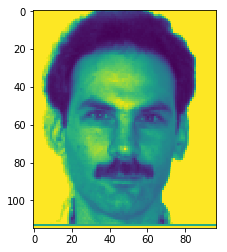

In [17]:
plt.imshow(train[9].reshape(115,97))

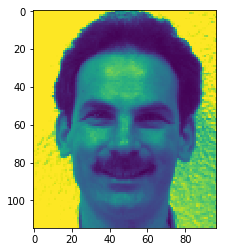

In [18]:
plt.imshow(test[2].reshape(115,97))

In [19]:
# PCA
cov = np.cov(train.transpose())
eigen_values, eigen_vectors = np.linalg.eigh(cov)
W_pca = eigen_vectors[:,eigen_values.argsort()[::-1]]

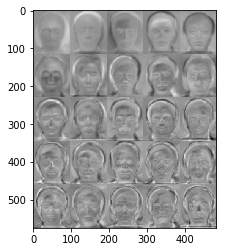

In [53]:
plt.imshow(im_concatenate(W_pca[:,:25]),cmap='binary')
plt.imsave('png/eigenface.png',im_concatenate(W_pca[:,:25]),cmap='binary')

In [54]:
W_pca_whit = eigen_vectors[:,eigen_values.argsort()[::-1]][:,:25]/np.sqrt(eigen_values[eigen_values.argsort()[::-1]][:25])

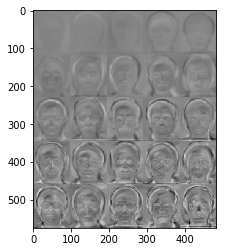

In [55]:
plt.imshow(im_concatenate(W_pca_whit[:,:25]),cmap='binary')
plt.imsave('png/eigenface_whit.png',im_concatenate(W_pca_whit[:,:25]),cmap='binary')

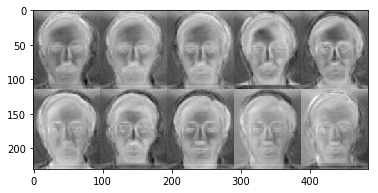

In [23]:
reconstruct = np.dot(np.dot(train[sorted(np.random.choice(135,10)),:],W_pca[:,:25]),W_pca[:,:25].T)
re = plot_reconstruct(reconstruct)
plt.imsave('png/eigenface_reconstruct.png',re,cmap='binary')

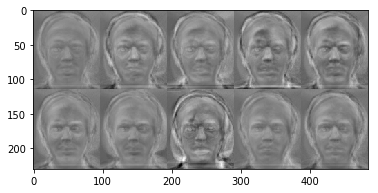

In [24]:
reconstruct = np.dot(np.dot(train[sorted(np.random.choice(135,10)),:],W_pca_whit[:,:25]),W_pca_whit[:,:25].T)
re = plot_reconstruct(reconstruct)
plt.imsave('png/eigenface_whit_reconstruct.png',re,cmap='binary')

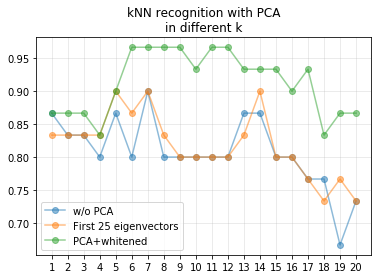

In [60]:
acc = np.zeros((3,20))
for i in range(20):
    acc[0][i] = knn(i+1,train,test,test_label)
    acc[1][i] = knn(i+1,np.dot(train,W_pca[:,:25]),np.dot(test,W_pca[:,:25]),test_label)
    acc[2][i] = knn(i+1,np.dot(train,W_pca_whit),np.dot(test,W_pca_whit),test_label)
plt.plot(np.linspace(1,20,20),acc[0],'o-',alpha=0.5)
plt.plot(np.linspace(1,20,20),acc[1],'o-',alpha=0.5)
plt.plot(np.linspace(1,20,20),acc[2],'o-',alpha=0.5)
plt.xticks(np.arange(1,21,step=1))
plt.grid('on',alpha=0.3)
plt.legend(['w/o PCA','First 25 eigenvectors','PCA+whitened'],loc='best')
plt.title('kNN recognition with PCA\nin different k')
plt.savefig('png/PCA_recog.png')

In [27]:
gamma = 0.002
e = np.ones((135,135))/135
K_rbf = rbf_kernel(train,train,gamma)
Kc_rbf = K_rbf - np.dot(e,K_rbf) - np.dot(K_rbf,e) + np.dot(np.dot(e,K_rbf),e)
eigen_values3, eigen_vectors3 = np.linalg.eig(Kc_rbf)
U_rbf = eigen_vectors3[:,eigen_values3.argsort()[::-1]]
Kt_rbf = rbf_kernel(test,train,gamma)

K_poly = poly_kernel(train,train)
Kc_poly = K_poly - np.dot(e,K_poly) - np.dot(K_poly,e) + np.dot(np.dot(e,K_poly),e)
eigen_values3, eigen_vectors3 = np.linalg.eig(Kc_poly)
U_poly = eigen_vectors3[:,eigen_values3.argsort()[::-1]]
Kt_poly = poly_kernel(test,train)

K_l = linear_kernel(train,train)
Kc_l = K_l - np.dot(e,K_l) - np.dot(K_l,e) + np.dot(np.dot(e,K_l),e)
eigen_values3, eigen_vectors3 = np.linalg.eig(Kc_l)
U_l = eigen_vectors3[:,eigen_values3.argsort()[::-1]]
Kt_l = linear_kernel(test,train)

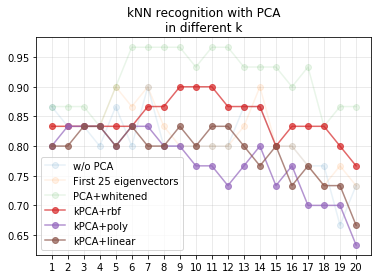

In [69]:
acc = np.zeros((6,20))
for i in range(20):
    acc[0][i] = knn(i+1,train,test,test_label)
    acc[1][i] = knn(i+1,np.dot(train,W_pca[:,:25]),np.dot(test,W_pca[:,:25]),test_label)
    acc[2][i] = knn(i+1,np.dot(train,W_pca_whit),np.dot(test,W_pca_whit),test_label)
    acc[3][i] = knn(i+1,np.dot(Kc_rbf,U_rbf[:,:25]),np.dot(Kt_rbf,U_rbf[:,:25]),test_label)
    acc[4][i] = knn(i+1,np.dot(K_poly,U_poly[:,:25]),np.dot(Kt_poly,U_poly[:,:25]),test_label)
    acc[5][i] = knn(i+1,np.dot(K_l,U_l[:,:25]),np.dot(Kt_l,U_l[:,:25]),test_label)
plt.plot(np.linspace(1,20,20),acc[0],'o-',alpha=0.1)
plt.plot(np.linspace(1,20,20),acc[1],'o-',alpha=0.1)
plt.plot(np.linspace(1,20,20),acc[2],'o-',alpha=0.1)
plt.plot(np.linspace(1,20,20),acc[3],'o-',alpha=0.7)
plt.plot(np.linspace(1,20,20),acc[4],'o-',alpha=0.7)
plt.plot(np.linspace(1,20,20),acc[5],'o-',alpha=0.7)
plt.xticks(np.arange(1,21,step=1))
plt.grid('on',alpha=0.3)
plt.legend(['w/o PCA','First 25 eigenvectors','PCA+whitened','kPCA+rbf','kPCA+poly','kPCA+linear'],loc='best')
plt.title('kNN recognition with PCA\nin different k')
plt.savefig('png/kPCA_recog.png')

In [70]:
for i in range(6):
    res_acc.append(max(acc[i]))

[0.9, 0.9, 0.9666666666666667, 0.9, 0.8333333333333334, 0.8333333333333334]

In [30]:
# LDA
train_project = np.dot(train,W_pca[:,:135-15]) # rank(Sw) is at most N-c
m,M = compute_mean(train_project)
Sw = compute_within_class(m,train_project)
Sb = compute_between_class(m,M)
eigen_values2, eigen_vectors2 = np.linalg.eig(np.dot(np.linalg.inv(Sw),Sb))
W_fld = eigen_vectors2[:,eigen_values2.real.argsort()[::-1]].real
W_lda=np.dot(W_pca[:,:120],W_fld)

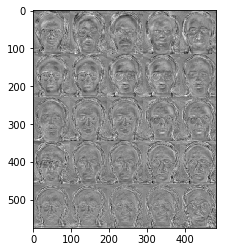

In [31]:
plt.imshow(im_concatenate(W_lda[:,:25].astype('float32')),cmap='binary')
plt.imsave('png/fisherface.png',im_concatenate(W_lda[:,:25].astype('float32')),cmap='binary')

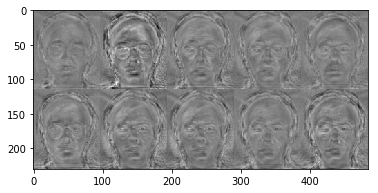

In [32]:
reconstruct = np.dot(np.dot(train[sorted(np.random.choice(135,10)),:],W_lda[:,:25]),W_lda[:,:25].T)
re = plot_reconstruct(reconstruct)
plt.imsave('png/fisherface_reconstruct.png',re,cmap='binary')

Text(0.5,1,'kNN recognition with LDA \nin different k')

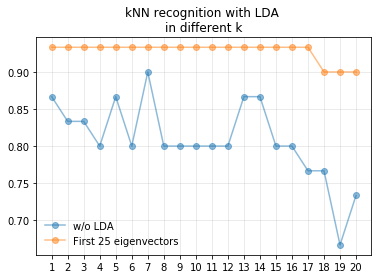

In [33]:
acc = np.zeros((2,20))
for i in range(20):
    acc[0][i] = knn(i+1,train,test,test_label)
    acc[1][i] = knn(i+1,np.dot(train,W_lda[:,:25]),np.dot(test,W_lda[:,:25]),test_label)

plt.plot(np.linspace(1,20,20),acc[0],'o-',alpha=0.5)
plt.plot(np.linspace(1,20,20),acc[1],'o-',alpha=0.5)
plt.xticks(np.arange(1,21,step=1))
plt.grid('on',alpha=0.3)
plt.legend(['w/o LDA','First 25 eigenvectors'],loc='best',frameon=False)
plt.title('kNN recognition with LDA \nin different k')
#plt.savefig('png/LDA_recog.png')

In [34]:
acc

array([[0.86666667, 0.83333333, 0.83333333, 0.8       , 0.86666667,
        0.8       , 0.9       , 0.8       , 0.8       , 0.8       ,
        0.8       , 0.8       , 0.86666667, 0.86666667, 0.8       ,
        0.8       , 0.76666667, 0.76666667, 0.66666667, 0.73333333],
       [0.93333333, 0.93333333, 0.93333333, 0.93333333, 0.93333333,
        0.93333333, 0.93333333, 0.93333333, 0.93333333, 0.93333333,
        0.93333333, 0.93333333, 0.93333333, 0.93333333, 0.93333333,
        0.93333333, 0.93333333, 0.9       , 0.9       , 0.9       ]])

In [35]:
m_k_rbf, M_k_rbf = compute_mean_kernel(K_rbf)
Sw_k_rbf = compute_within_class_kernel(K_rbf)
Sb_k_rbf = compute_between_class(m_k_rbf,M_k_rbf)
eigen_values4, eigen_vectors4 = np.linalg.eig(np.dot(np.linalg.inv(Sw_k_rbf),Sb_k_rbf))
W_kda_rbf = eigen_vectors4[:,eigen_values4.real.argsort()[::-1]].real

m_k_poly, M_k_poly = compute_mean_kernel(K_poly)
Sw_k_poly = compute_within_class_kernel(K_poly)
Sb_k_poly = compute_between_class(m_k_poly,M_k_poly)
eigen_values4, eigen_vectors4 = np.linalg.eig(np.dot(np.linalg.inv(Sw_k_poly),Sb_k_poly))
W_kda_poly = eigen_vectors4[:,eigen_values4.real.argsort()[::-1]].real

m_k_l, M_k_l = compute_mean_kernel(K_l)
Sw_k_l = compute_within_class_kernel(K_l)
Sb_k_l = compute_between_class(m_k_l,M_k_l)
eigen_values4, eigen_vectors4 = np.linalg.eig(np.dot(np.linalg.inv(Sw_k_l),Sb_k_l))
W_kda_l = eigen_vectors4[:,eigen_values4.real.argsort()[::-1]].real

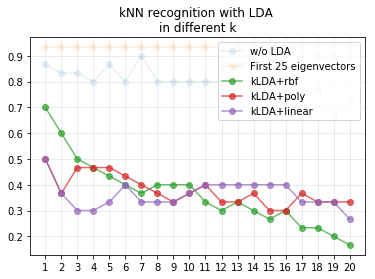

In [71]:
acc = np.zeros((5,20))
for i in range(20):
    acc[0][i] = knn(i+1,train,test,test_label)
    acc[1][i] = knn(i+1,np.dot(train,W_lda[:,:25]),np.dot(test,W_lda[:,:25]),test_label)
    acc[2][i] = knn(i+1,np.dot(K_rbf,W_kda_rbf[:,:25]),np.dot(Kt_rbf,W_kda_rbf[:,:25]),test_label)
    acc[3][i] = knn(i+1,np.dot(K_poly,W_kda_poly[:,:25]),np.dot(Kt_poly,W_kda_poly[:,:25]),test_label)
    acc[4][i] = knn(i+1,np.dot(K_l,W_kda_l[:,:25]),np.dot(Kt_l,W_kda_l[:,:25]),test_label)

plt.plot(np.linspace(1,20,20),acc[0],'o-',alpha=0.1)
plt.plot(np.linspace(1,20,20),acc[1],'o-',alpha=0.1)
plt.plot(np.linspace(1,20,20),acc[2],'o-',alpha=0.7)
plt.plot(np.linspace(1,20,20),acc[3],'o-',alpha=0.7)
plt.plot(np.linspace(1,20,20),acc[4],'o-',alpha=0.7)
plt.xticks(np.arange(1,21,step=1))
plt.grid('on',alpha=0.3)
plt.legend(['w/o LDA','First 25 eigenvectors','kLDA+rbf','kLDA+poly','kLDA+linear'],loc='upper right')
plt.title('kNN recognition with LDA \nin different k')
plt.savefig('png/kLDA_recog.png')

In [73]:
for i in range(1,5):
    res_acc.append(max(acc[i]))
res_acc

[0.9,
 0.9,
 0.9666666666666667,
 0.9,
 0.8333333333333334,
 0.8333333333333334,
 0.9333333333333333,
 0.7,
 0.5,
 0.5]

In [77]:
df = pd.DataFrame([res_acc],columns=['kNN','PCA','PCA+whitening','kPCA+rbf','kPCA+poly','kPCA+linear','LDA','kLCA+rbf','kLCA+poly','kLCA+linear'],index=['best acc'])
print(df)

,kNN,PCA,PCA+whitening,kPCA+rbf,kPCA+poly,kPCA+linear,LDA,kLCA+rbf,kLCA+poly,kLCA+linear
best acc,0.9,0.9,0.966667,0.9,0.833333,0.833333,0.933333,0.7,0.5,0.5
